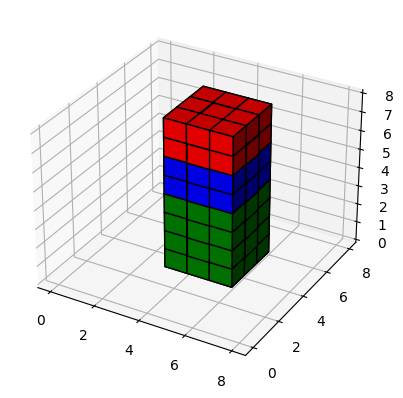

In [1]:
from artefact_nca.dataset.voxel_dataset import VoxelDataset
from artefact_nca.model.voxel_ca_model import VoxelCAModel
from artefact_nca.trainer.voxel_ca_trainer import VoxelCATrainer


import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z < 4)
cube2 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 4) & (z < 6)
cube3 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 6) & (z < 8) 

# link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | cube3

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[cube3] = 'red'
colors[cube1] = 'green'
colors[cube2] = 'blue'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

from artefact_nca.utils.minecraft.voxel_utils import voxel_to_numeric

voxel, target_unique_val_dict = voxel_to_numeric(colors)


In [2]:
import torch
print(torch.cuda.is_available())


False


In [3]:
import attr
import torch.nn.functional as F
import torch
import numpy as np
from einops import rearrange

@attr.s
class CustomMSETrainer(VoxelCATrainer):


    def get_fitness(self, grown_robot):
        return 0
    
    def custom_seed(self, batch_size):
        depth = self.dataset.depth
        height = self.dataset.height
        width = self.dataset.width
        
        seed = np.ones(
                    (batch_size, depth, height, width, self.num_channels)
                ) * 10
        return torch.from_numpy(seed).float().to(self.device)
    
    def train_func(self, x, targets, steps=1):
        self.optimizer.zero_grad()
        x = self.model(x, steps=steps, rearrange_output=False)
        fitness = self.get_fitness(x)
    
        loss, iou_loss = self.get_loss(x, targets)

        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        x = rearrange(x, "b c d h w -> b d h w c")
        out = {
            "out": x,
            "metrics": {"loss": loss.item(), "iou_loss": iou_loss.item()},
            "loss": loss,
        }
        return out

    def train_iter(self, batch_size=32, iteration=0):
        batch, targets, indices = self.sample_batch(batch_size)
        targets = targets.long()

        batch = self.custom_seed(batch_size)
        if self.use_sample_pool:
            with torch.no_grad():
                loss_rank = (
                    self.rank_loss_function(batch, targets)
                    .detach()
                    .cpu()
                    .numpy()
                    .argsort()[::-1]
                )
                batch = batch[loss_rank.copy()]
                batch[:1] = torch.from_numpy(self.get_seed()).to(self.device)

                if self.damage:
                    self.apply_damage(batch)

        steps = np.random.randint(self.min_steps, self.max_steps)
        if self.half_precision:
            with torch.cuda.amp.autocast():
                out_dict = self.train_func(batch, targets, steps)
        else:
            out_dict = self.train_func(batch, targets, steps)
        out, loss, metrics = out_dict["out"], out_dict["loss"], out_dict["metrics"]

        if self.update_dataset and self.use_sample_pool:
            self.update_dataset_function(out, indices)
        out_dict["prev_batch"] = batch.detach().cpu().numpy()
        out_dict["post_batch"] = out.detach().cpu().numpy()
        return out_dict    


In [4]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

Before --- After


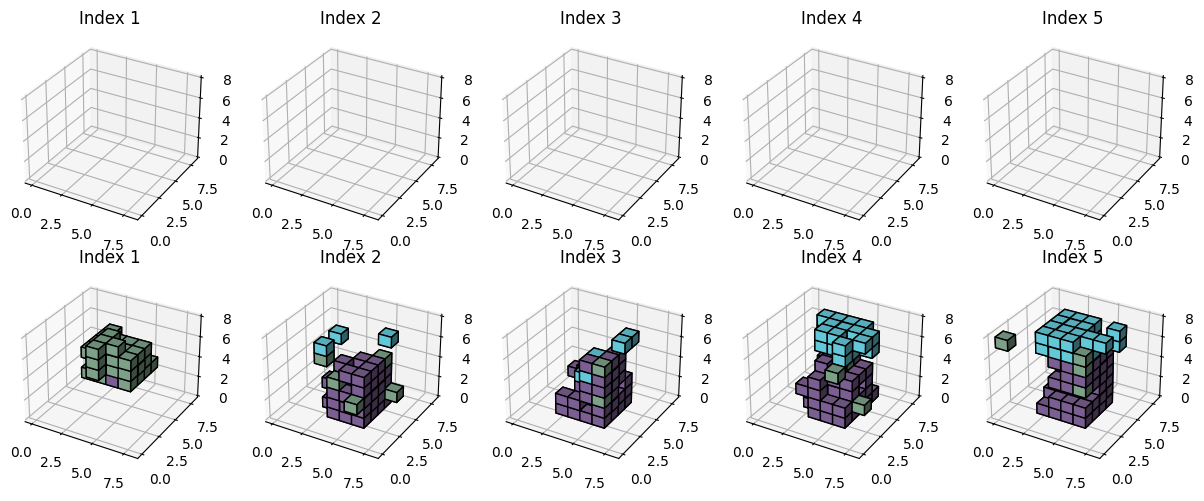

loss:0.453531414270401--iou_loss:0.645652174949646:  14%|█▍        | 207/1500 [04:50<30:11,  1.40s/it]   


KeyboardInterrupt: 

In [5]:
ct.train()

### View model weights

In [10]:
for name, W in ct.model.named_parameters():
    print(name, W)

perception_net.conv1.weight Parameter containing:
tensor([[[[[ 0.1164, -0.0551,  0.1248],
           [ 0.0172,  0.0098,  0.0475],
           [-0.0621,  0.0602, -0.0324]],

          [[-0.0165, -0.0352, -0.0182],
           [-0.0984, -0.2651, -0.0501],
           [ 0.0447, -0.0501,  0.0723]],

          [[ 0.1295, -0.0338, -0.0880],
           [ 0.1178, -0.0816,  0.0084],
           [-0.1791, -0.0273, -0.0918]]]],



        [[[[-0.0725,  0.1529,  0.0015],
           [ 0.0087,  0.0806, -0.0461],
           [-0.0403, -0.0478,  0.0714]],

          [[ 0.0689,  0.0656, -0.1145],
           [-0.1245,  0.1184, -0.0552],
           [ 0.0629, -0.0603,  0.0333]],

          [[-0.0532,  0.0287,  0.0904],
           [-0.1808, -0.0265,  0.1321],
           [-0.0617,  0.0384,  0.2570]]]],



        [[[[ 0.0746,  0.0200, -0.0328],
           [ 0.1455,  0.1722,  0.0958],
           [ 0.2688,  0.0124, -0.1823]],

          [[-0.1076, -0.0876, -0.2261],
           [-0.0494, -0.1725, -0.0633],
        

In [11]:
with torch.no_grad():
    for name, W in ct.model.named_parameters():
        W += torch.ones_like(W)

In [12]:
for name, W in ct.model.named_parameters():
    print(name, W)

perception_net.conv1.weight Parameter containing:
tensor([[[[[1.1164, 0.9449, 1.1248],
           [1.0172, 1.0098, 1.0475],
           [0.9379, 1.0602, 0.9676]],

          [[0.9835, 0.9648, 0.9818],
           [0.9016, 0.7349, 0.9499],
           [1.0447, 0.9499, 1.0723]],

          [[1.1295, 0.9662, 0.9120],
           [1.1178, 0.9184, 1.0084],
           [0.8209, 0.9727, 0.9082]]]],



        [[[[0.9275, 1.1529, 1.0015],
           [1.0087, 1.0806, 0.9539],
           [0.9597, 0.9522, 1.0714]],

          [[1.0689, 1.0656, 0.8855],
           [0.8755, 1.1184, 0.9448],
           [1.0629, 0.9397, 1.0333]],

          [[0.9468, 1.0287, 1.0904],
           [0.8192, 0.9735, 1.1321],
           [0.9383, 1.0384, 1.2570]]]],



        [[[[1.0746, 1.0200, 0.9672],
           [1.1455, 1.1722, 1.0958],
           [1.2688, 1.0124, 0.8177]],

          [[0.8924, 0.9124, 0.7739],
           [0.9506, 0.8275, 0.9367],
           [0.9920, 0.9665, 0.9474]],

          [[1.1593, 1.0457, 1.0533],
 

In [13]:
weights = ct.model.state_dict()

#### Save model

In [14]:
torch.save({"model":ct.model.state_dict()}, "test_model.pt")

#### Load Model

In [15]:
ct.load_model("test_model.pt", load_optimizer_and_scheduler = False)

### Create new trainer from pretrained model

In [16]:
ct = CustomMSETrainer.from_config(
                    "test_config.yaml",
                    config={
                        "pretrained_path":"test_model.pt",
                        "dataset_config":{"target_voxel":voxel, "target_unique_val_dict":target_unique_val_dict},
                        "use_cuda":False
                    }
                )

### Visualize output of NCA

In [17]:
from IPython.display import clear_output
from artefact_nca.utils.minecraft.voxel_utils import replace_colors

def visualize_output(ct, out):
    clear_output()
    out = rearrange(out, 'b d h w c -> b w d h c')
    argmax = np.argmax(out[:, :, :, :, :ct.num_categories], -1)
    out = replace_colors(argmax, ct.dataset.target_color_dict)[0]
    fig = plt.figure()
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(out, facecolors=out, edgecolor='k')
    
    plt.show()
    return argmax

<Figure size 640x480 with 0 Axes>

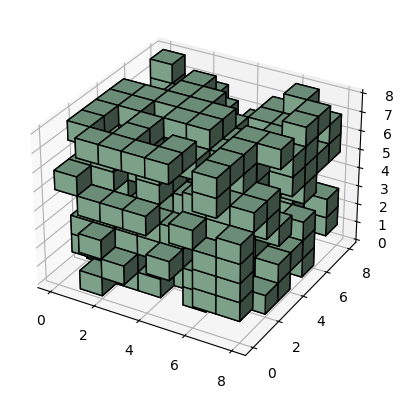

In [22]:
seed = np.ones(
            (1, 8, 8, 8, ct.num_channels)
        )
seed[:, :, :, :, 1:] = 10.0
seed = torch.from_numpy(seed).float().to(ct.device)

with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=seed)

_ = visualize_output(ct, final.cpu().numpy())

#### another step

<Figure size 640x480 with 0 Axes>

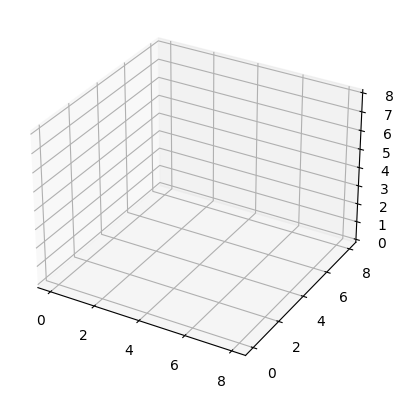

In [33]:
with torch.no_grad():
    final, states, life_masks = ct.rollout(steps=1, initial=final)

_ = visualize_output(ct, final.cpu().numpy())